In [1]:
%gui qt

import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
from skimage.exposure import rescale_intensity
import imageio

import utoolbox.utils.files as fileutils
from utoolbox.container import Image, Volume

### Parameters

In [2]:
n_bins = 24

### Environment presets

In [3]:
bins = np.linspace(-np.pi, np.pi, n_bins+1, dtype=np.float)
polar_grid = np.linspace(-np.pi, np.pi, n_bins, endpoint=False)

Create plots for preview images.

TypeError: set_xticks() got an unexpected keyword argument 'y'

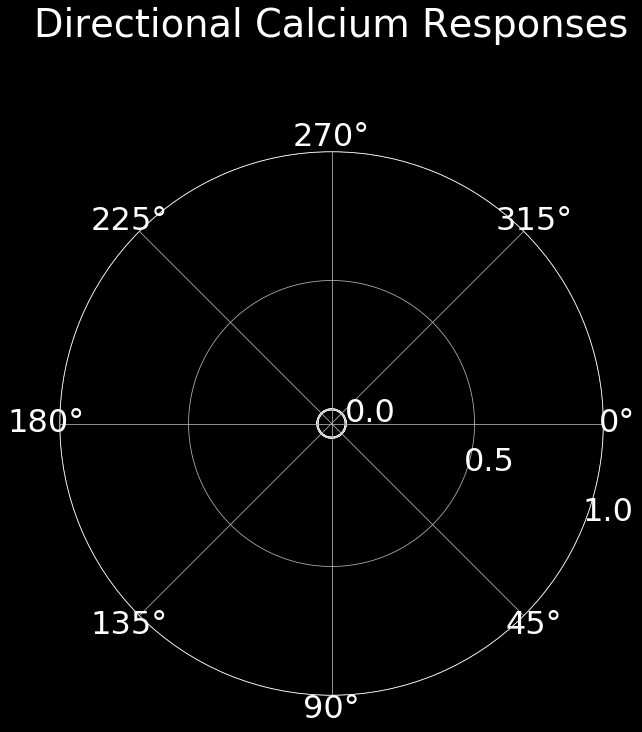

In [31]:
plt.rcParams['font.size'] = 32
plt.rcParams['text.color'] = 'w'
plt.rcParams['axes.facecolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['figure.facecolor'] = 'k'
plt.rcParams['savefig.facecolor'] = 'k'
plt.rcParams['savefig.edgecolor'] = 'k'

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=0.5)
ax_d = fig.add_subplot(1, 1, 1, projection='polar')
ax_d.set_title('Directional Calcium Responses', y=1.2)
ax_d.set_theta_direction(-1)
ax_d.set_theta_zero_location('E')
#bar_d = ax_d.bar(polar_grid, np.zeros_like(polar_grid), width=2*np.pi/n_bins, color='lightblue', edgecolor='k')
bar_d = ax_d.bar(polar_grid, np.zeros_like(polar_grid), width=2*np.pi/n_bins, color=(1., 1., 1., 0.25), edgecolor='w', fill=True, linewidth=2)
ax_d.set_yticks([0, 0.5, 1])

### List files

In [5]:
source_folder = fileutils.get_local_directory()
print(source_folder)
file_list = fileutils.list_files(
    source_folder, 
    name_filters=[fileutils.ExtensionFilter('tif')]
)

/Users/Andy/Desktop/utoolbox/data/20171201_RFiSHp2aLFCYC/decon/488


In [6]:
mask_folder = os.path.join(source_folder, "mask")
if not os.path.exists(mask_folder):
    raise RuntimeError("no valid mask information found")
    
contour_folder = os.path.join(source_folder, "contour")
if not os.path.exists(contour_folder):
    raise RuntimeError("no valid contour information found")

Generate output folder.

In [7]:
intensity_folder = os.path.join(source_folder, 'intensity')
if not os.path.exists(intensity_folder):
    os.makedirs(intensity_folder)

### Iterate over the volumes

In [8]:
def build_lut(contour):
    shape = contour.shape
    
    # convert to index
    contour = np.where(contour == True)
    x = contour[1].astype(np.float)
    y = contour[0].astype(np.float)
    cx = np.mean(x)
    cy = np.mean(y)
    
    gy, gx = np.mgrid[0:shape[1], 0:shape[0]]
    gx = gx.astype(np.float) - cx
    gy = gy.astype(np.float) - cy
    
    theta = np.arctan2(gy, gx)
    
    # cardinal direction
    return np.digitize(theta, bins) - 1

In [9]:
intensity_map = {}

In [10]:
bar = progressbar.ProgressBar()
frame = 0
for file_path in bar(file_list):
    file_name = os.path.basename(file_path)

    # load contour
    contour_file_path = os.path.join(contour_folder, file_name)
    contour = Image(contour_file_path)
    contour = rescale_intensity(contour, out_range=(0., 1.))

    # identify pixel regions
    lut = build_lut(contour)
    
    # load raw data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        raw = Volume(file_path)
    raw = rescale_intensity(raw, out_range=(0., 1.))
    # XY MIP
    raw = np.amax(raw, axis=0)
    
    # mask unwanted regions
    mask_file_path = os.path.join(mask_folder, file_name)
    mask = Image(mask_file_path)
    raw[mask == 0] = 0.
    
    # estimate directional average
    intensity = np.zeros(n_bins, dtype=np.float)
    n_pixels, _ = np.histogram(lut, bins=n_bins)

    for i in range(n_bins):
        intensity[i] = raw[lut == i].sum()
    intensity /= n_pixels
    
    # export the result
    intensity_map[frame] = pd.DataFrame({
        'intensity': intensity
    })
    frame += 1
intensity_map = pd.concat(intensity_map.values(), axis=0, keys=intensity_map.keys())

100% (10 of 10) |#########################| Elapsed Time: 0:00:21 Time: 0:00:21


Get baseline.

In [11]:
mean_i = intensity_map['intensity'].max()

Calculate relative intensity.

In [12]:
intensity_map['rel_intensity'] = intensity_map['intensity'] / mean_i

Save result as CSV.

In [13]:
intensity_map.to_csv(os.path.join(intensity_folder, 'summary.csv'))

Generate previews.

In [28]:
bar = progressbar.ProgressBar()
frame = 0
for file_path in bar(file_list):
    file_name = os.path.basename(file_path)
    
    for obj, height in zip(bar_d, intensity_map.loc[frame, 'rel_intensity']):
        obj.set_height(height)
    fig.canvas.draw()
    
    # save the preview
    fig.savefig(os.path.join(intensity_folder, file_name))
    
    frame += 1

100% (10 of 10) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01
